# Google Play Store - Predicting User Ratings

## Data Preparation

In [33]:
import pandas as pd
import numpy as np 

# Import data and set to dataframe
playstore = pd.read_csv('Google_Playstore.csv')

# Drop irrelevant columns (columns with descriptive info that isn't helpful for our purposes)
playstore = playstore.drop(["Privacy Policy","Developer Email","Developer Website","App Id","App Name","Installs","Developer Id","Size","Scraped Time","Released","Last Updated","Minimum Android"],axis=1)

# Drop rows with null values in potential target variable columns
playstore.dropna(subset=["Rating"], inplace=True)
playstore = playstore[playstore['Rating'] != 0]

# Fill categorical missing data with NA
playstore = playstore.fillna("NA")

# Create new variable for games potentially aimed at kids (using my own discretion)
# Criteria: Category = Action, Adventure, Arcade, Casual, Entertainment, Puzzle, Racing, Role-Playing, or Simulation
# Criteria: Content Rating = Everyone

def child(category,content):
    if category == "Action" and content == "Everyone":
        return 1
    if category == "Adventure" and content == "Everyone":
        return 1
    if category == "Arcade" and content == "Everyone":
        return 1
    if category == "Casual" and content == "Everyone":
        return 1
    if category == "Entertainment" and content == "Everyone":
        return 1
    if category == "Puzzle" and content == "Everyone":
        return 1
    if category == "Racing" and content == "Everyone":
        return 1
    if category == "Role-Playing" and content == "Everyone":
        return 1
    if category == "Simulation" and content == "Everyone":
        return 1
    else:
        return 0
      
playstore["child"] = playstore.apply(lambda x: child(x["Category"], x["Content Rating"]), axis=1)

# Since min installs and max installs are highly correlated, we will remove min installs as it is less specific
playstore = playstore.drop("Minimum Installs", axis=1)

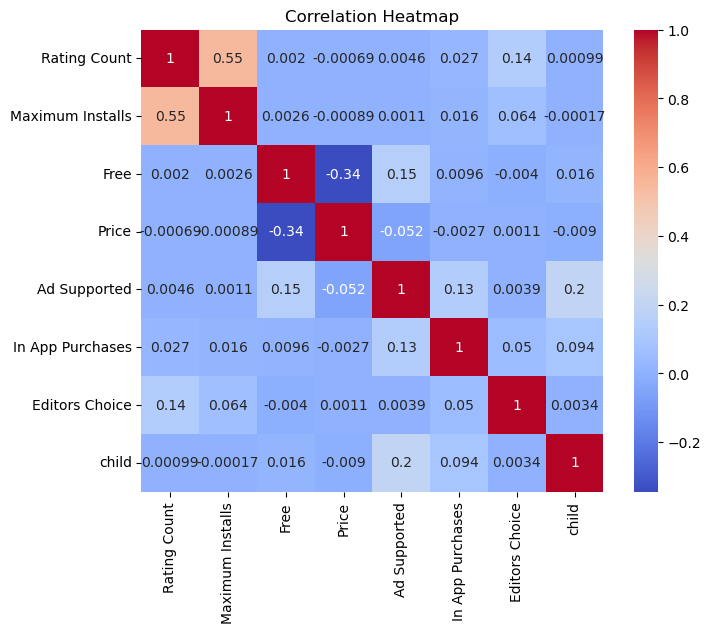

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

## Create a correlation matrix to investigate for multicollinearity
# Calculate the correlation matrix
playstore_indep = playstore.drop("Rating", axis=1)
correlation_matrix = playstore_indep.corr()

# Create a heatmap figure
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

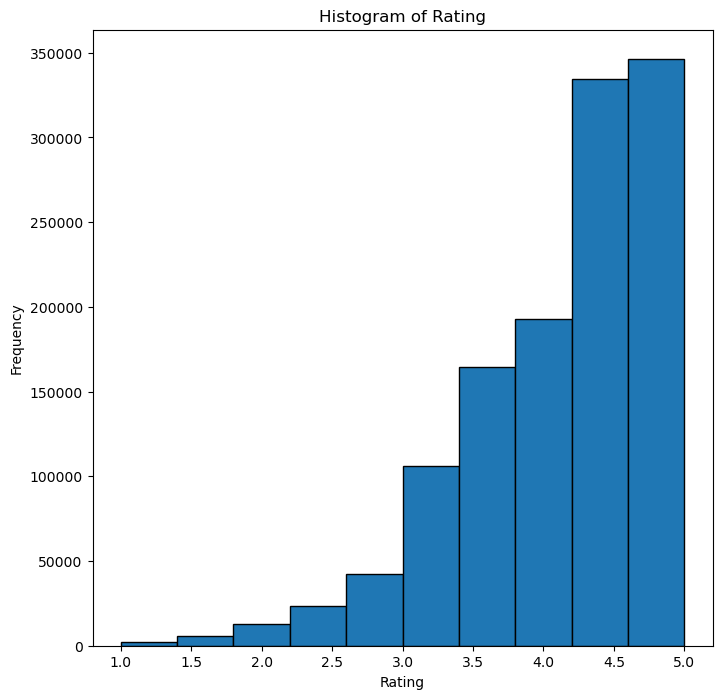

In [32]:
# Create a histogram for dependent variable
plt.figure(figsize=(8, 8))
plt.hist(playstore["Rating"], bins=10, edgecolor='black')
plt.title('Histogram of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

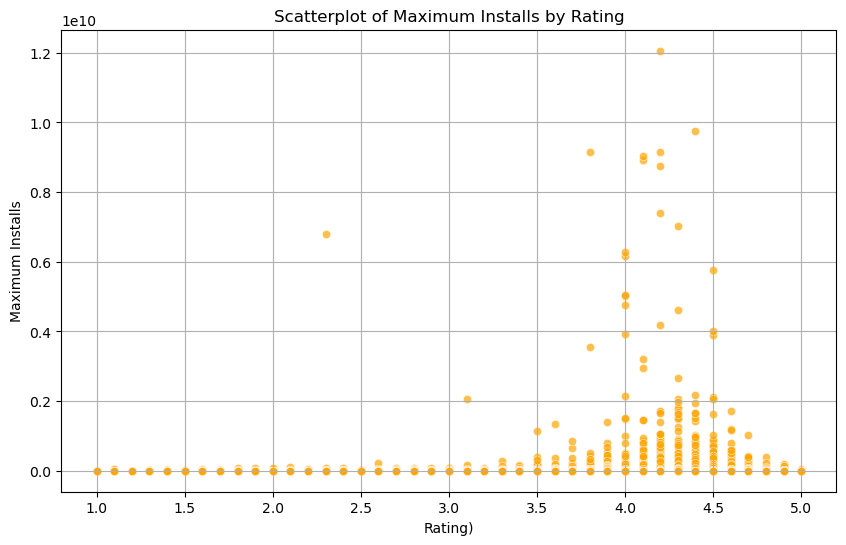

In [6]:
# Create a scatterplot for Rating by certain continuous variables to observe for skew
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='Maximum Installs', data=playstore, color='orange', alpha=0.7)
plt.title('Scatterplot of Maximum Installs by Rating')
plt.xlabel('Rating)')
plt.ylabel('Maximum Installs')
plt.grid(True)
plt.show()

In [8]:
# Attempt to account for skew by creating transformations of certain quantitative variables
playstore['Log_RatingCount'] = np.log(playstore['Rating Count'] + 1)  # Adding 1 to avoid log(0)
playstore['Log_MaxInstalls'] = np.log(playstore['Maximum Installs'] + 1)  # Adding 1 to avoid log(0)
playstore['Log_Price'] = np.log(playstore['Price'] + 1)  # Adding 1 to avoid log(0)

In [9]:
# Create dummy coded variables for categorical predictors
playstore = pd.get_dummies(playstore, columns=['Category','Free','Currency','Content Rating','Ad Supported','In App Purchases','Editors Choice'], drop_first=True)
playstore

,Rating,Rating Count,Maximum Installs,Price,child,Log_RatingCount,Log_MaxInstalls,Log_Price,Category_Adventure,Category_Arcade,...,Currency_VND,Currency_XXX,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Ad Supported_True,In App Purchases_True,Editors Choice_True
1,4.4,64.0,7662,0.0,0,4.174387,8.944159,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,5.0,5.0,19,0.0,0,1.791759,2.995732,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
6,4.5,12.0,2567,0.0,0,2.564949,7.850883,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
7,2.0,39.0,702,0.0,0,3.688879,6.555357,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,4.7,820.0,62433,0.0,0,6.710523,11.041865,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312933,4.0,344.0,814548,0.0,0,5.843544,13.610390,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
2312938,3.4,17.0,1980,0.0,0,2.890372,7.591357,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
2312939,4.3,16775.0,337109,0.0,0,9.727705,12.728165,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2312942,3.5,8.0,2635,0.0,0,2.197225,7.877018,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [10]:
# Remove outliers
def remove_outliers_iqr(out_df, column):
    Q1 = out_df[column].quantile(0.25)
    Q3 = out_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = out_df[(out_df[column] < lower_bound) | (out_df[column] > upper_bound)]
    cleaned_df = out_df[(out_df[column] >= lower_bound) & (out_df[column] <= upper_bound)]
    return cleaned_df, outliers

cleaned_df = playstore.copy()
outliers_df = pd.DataFrame()
for column in cleaned_df.columns:
    cleaned_df, outliers = remove_outliers_iqr(cleaned_df, column)
    outliers_df = pd.concat([outliers_df, outliers])

In [11]:
print("Cleaned DataFrame without outliers:")
print(len(cleaned_df))
print("\nOutliers:")
print(len(outliers_df))

Cleaned DataFrame without outliers:
46877

Outliers:
1183422


In [12]:
# View descriptive statistics for playstore dataframe
playstore.describe(include='all')

,Rating,Rating Count,Maximum Installs,Price,child,Log_RatingCount,Log_MaxInstalls,Log_Price,Category_Adventure,Category_Arcade,...,Currency_VND,Currency_XXX,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Ad Supported_True,In App Purchases_True,Editors Choice_True
count,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,...,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06,1.230299e+06
mean,4.100915e+00,5.332570e+03,6.003751e+05,9.404793e-02,1.501984e-01,4.145563e+00,8.868494e+00,2.821117e-02,1.278795e-02,2.464035e-02,...,8.128105e-07,3.511342e-04,8.634950e-01,1.782494e-02,2.967165e-02,8.883857e-02,1.016013e-04,5.732647e-01,1.257711e-01,6.933274e-04
std,6.891015e-01,2.894363e+05,3.229278e+07,1.877317e+00,3.572660e-01,2.090160e+00,2.537877e+00,2.161184e-01,1.123585e-01,1.550265e-01,...,9.015601e-04,1.873529e-02,3.433242e-01,1.323149e-01,1.696799e-01,2.845107e-01,1.007924e-02,4.946034e-01,3.315913e-01,2.632199e-02
min,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.791759e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.800000e+00,1.200000e+01,1.267000e+03,0.000000e+00,0.000000e+00,2.564949e+00,7.145196e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.200000e+00,3.500000e+01,5.634000e+03,0.000000e+00,0.000000e+00,3.583519e+00,8.636752e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.600000e+00,1.780000e+02,3.349600e+04,0.000000e+00,0.000000e+00,5.187386e+00,1.041921e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,1.385576e+08,1.205763e+10,3.999900e+02,1.000000e+00,1.874680e+01,2.321296e+01,5.993936e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [13]:
# View descriptive statistics for cleaned dataframe to compare
cleaned_df.describe(include='all')

,Rating,Rating Count,Maximum Installs,Price,child,Log_RatingCount,Log_MaxInstalls,Log_Price,Category_Adventure,Category_Arcade,...,Currency_VND,Currency_XXX,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Ad Supported_True,In App Purchases_True,Editors Choice_True
count,46877.000000,46877.000000,46877.000000,46877.0,46877.0,46877.000000,46877.000000,46877.0,46877.0,46877.0,...,46877.0,46877.0,46877.0,46877.0,46877.0,46877.0,46877.0,46877.000000,46877.0,46877.0
mean,4.063080,40.846300,6004.099622,0.0,0.0,3.173119,7.855907,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.489686,0.0,0.0
std,0.618446,55.799904,7112.376491,0.0,0.0,1.002310,1.504295,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499899,0.0,0.0
min,2.600000,5.000000,29.000000,0.0,0.0,1.791759,3.401197,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
25%,3.700000,9.000000,973.000000,0.0,0.0,2.302585,6.881411,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
50%,4.100000,19.000000,2961.000000,0.0,0.0,2.995732,7.993620,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
75%,4.500000,47.000000,8380.000000,0.0,0.0,3.871201,9.033723,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
max,5.000000,432.000000,30762.000000,0.0,0.0,6.070738,10.334068,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0


## Model Building and Testing

In [14]:
# Perform Variable Selection using a Stepwise Regression
import statsmodels.api as sm

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.10,
                       verbose=True):

    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))

        if not changed:
            break

    return included

In [15]:
def stepwise_selection_results():
    X = cleaned_df.drop("Rating", axis=1)
    y = pd.DataFrame(cleaned_df, columns=["Rating"])

    result = stepwise_selection(X, y, verbose = True)
    print("resulting features:")
    print(result)

stepwise_selection_results()

/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Content Rating_Everyone        with p-value 0.0


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Currency_USD                   with p-value 0.0


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Log_MaxInstalls                with p-value 0.0


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Rating Count                   with p-value 0.0


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Category_Tools                 with p-value 0.0


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Log_RatingCount                with p-value 0.0
Drop Rating Count                   with p-value 0.648554


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Free_True                      with p-value 0.0


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Ad Supported_True              with p-value 1.02035e-27


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add Maximum Installs               with p-value 9.89827e-08


/var/folders/5t/9csb4_7j7v95ppmph_tyc5n00000gn/T/ipykernel_777/476544627.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


resulting features:
['Content Rating_Everyone', 'Currency_USD', 'Log_MaxInstalls', 'Category_Tools', 'Log_RatingCount', 'Free_True', 'Ad Supported_True', 'Maximum Installs']


In [16]:
## Apply results to the dataframe
cleaned_df2 = cleaned_df[['Rating','Log_MaxInstalls', 'Log_RatingCount', 'Content Rating_Everyone', 'Currency_USD', 'Free_True', 'Category_Tools', 'Ad Supported_True']]
cleaned_df2

,Rating,Log_MaxInstalls,Log_RatingCount,Content Rating_Everyone,Currency_USD,Free_True,Category_Tools,Ad Supported_True
1,4.4,8.944159,4.174387,1,1,1,1,1
17,5.0,4.143135,1.945910,1,1,1,1,0
24,4.2,9.958212,3.583519,1,1,1,1,1
45,4.3,7.242082,3.044522,1,1,1,1,1
56,3.8,9.512295,3.465736,1,1,1,1,1
...,...,...,...,...,...,...,...,...
2312499,4.5,7.969704,3.295837,1,1,1,1,0
2312625,2.6,5.814131,1.791759,1,1,1,1,0
2312684,3.5,6.986566,2.197225,1,1,1,1,1
2312849,4.9,6.115892,2.197225,1,1,1,1,0


In [17]:
# Split dataset into training and test datasets 70-30
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(cleaned_df2.drop("Rating",axis=1), cleaned_df2["Rating"], test_size=0.3, random_state=2024)

print(Xtrain)
print(Xtest)
print(ytrain)
print(ytest)

         Log_MaxInstalls  Log_RatingCount  Content Rating_Everyone  \
1596455         9.642642         3.761200                        1   
1323967         8.503094         3.332205                        1   
927790          7.518607         2.772589                        1   
589050          8.868273         4.499810                        1   
462479          7.021084         1.791759                        1   
...                  ...              ...                      ...   
392376          8.200837         3.713572                        1   
121666          9.392912         3.663562                        1   
1492035         7.015712         2.197225                        1   
1751551         9.260938         3.737670                        1   
385019          4.532599         2.079442                        1   

         Currency_USD  Free_True  Category_Tools  Ad Supported_True  
1596455             1          1               1                  1  
1323967            

In [18]:
# Split the train dataset into training and validation
from sklearn.model_selection import train_test_split

Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=2024)

print(Xtrain)
print(Xval)
print(ytrain)
print(yval)

         Log_MaxInstalls  Log_RatingCount  Content Rating_Everyone  \
494184          9.379492         4.262680                        1   
1076615         3.610918         2.079442                        1   
1781619         7.104144         2.708050                        1   
1986924         7.859799         2.302585                        1   
2085515        10.013507         5.365976                        1   
...                  ...              ...                      ...   
2176043         6.716595         1.945910                        1   
2171349         6.621406         2.397895                        1   
1378896         7.016610         2.302585                        1   
858604          9.013474         3.850148                        1   
447652          7.762596         2.397895                        1   

         Currency_USD  Free_True  Category_Tools  Ad Supported_True  
494184              1          1               1                  1  
1076615            

In [20]:
## Create Linear Regression Model using validation dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Add a constant term for the intercept
Xtrain_const = sm.add_constant(Xtrain)
Xval_const = sm.add_constant(Xval)
Xtest_const = sm.add_constant(Xtest)

# Fit the model
model = sm.OLS(ytrain, Xtrain_const).fit()
print(model.summary())

# Predictions
ypred_train = model.predict(Xtrain_const)
ypred_val = model.predict(Xval_const)

# Goodness of fit statistics
mae = mean_absolute_error(yval, ypred_val)
mse = mean_squared_error(yval, ypred_val)
rmse = np.sqrt(mse)
r2 = model.rsquared
adjusted_r2 = model.rsquared_adj
f_statistic = model.fvalue
f_pvalue = model.f_pvalue

print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("F-statistic:", f_statistic)
print("p-value:", f_pvalue)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     1930.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        05:32:43   Log-Likelihood:                -18998.
No. Observations:               22969   AIC:                         3.800e+04
Df Residuals:                   22965   BIC:                         3.804e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Log_MaxInstalls           

## This r-squared value isn't great, so let's try another model to see if it will perform any better

In [30]:
## Create Random Forest Regression Model using validation dataset
from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor(n_estimators=100, random_state=2024)
model.fit(Xtrain, ytrain)

# Predictions
y_pred = model.predict(Xval)

# Goodness of fit statistics
mae = mean_absolute_error(yval, ypred_val)
mse = mean_squared_error(yval, ypred_val)
rmse = np.sqrt(mse)
r2 = r2_score(yval, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(yval) - 1) / (len(yval) - Xval.shape[1] - 1)

print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

R-squared: 0.019907126751703585
Adjusted R-squared: 0.019209622673548088
MAE: 0.48020337819772
MSE: 0.37002014722663074
RMSE: 0.60829281372266


## This model appears to perform much worse, so let's continue on with the Linear Regression Model

In [21]:
## Test Linear Regression Model using testing dataset

# Predictions
ypred_train = model.predict(Xtrain_const)
ypred_test = model.predict(Xtest_const)

# Goodness of fit statistics
mae = mean_absolute_error(ytest, ypred_test)
mse = mean_squared_error(ytest, ypred_test)
rmse = np.sqrt(mse)
r2 = model.rsquared
adjusted_r2 = model.rsquared_adj
f_statistic = model.fvalue
f_pvalue = model.f_pvalue

print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("F-statistic:", f_statistic)
print("p-value:", f_pvalue)

R-squared: 0.20135764383483268
Adjusted R-squared: 0.20125331433043492
MAE: 0.4409339619359956
MSE: 0.3043300066157117
RMSE: 0.5516611338636352
F-statistic: 1930.0162978544415
p-value: 0.0


## Graphs:

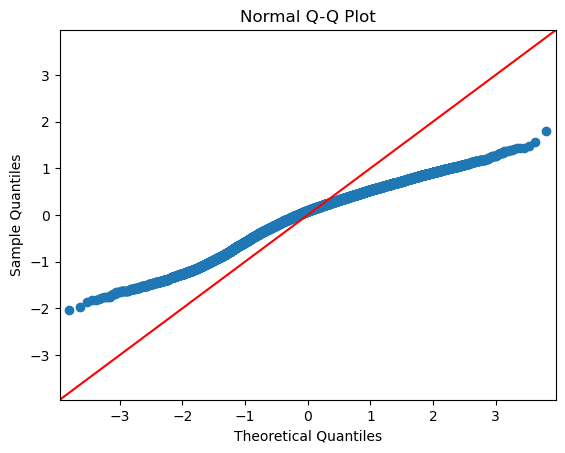

In [192]:
# Q-Q plot for residuals
residuals = ytest - ypred_test

sm.qqplot(residuals, line='45')
plt.title('Normal Q-Q Plot')
plt.show()

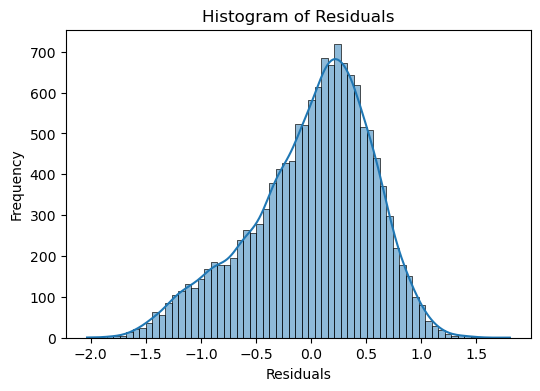

In [194]:
# Create a histogram for the residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

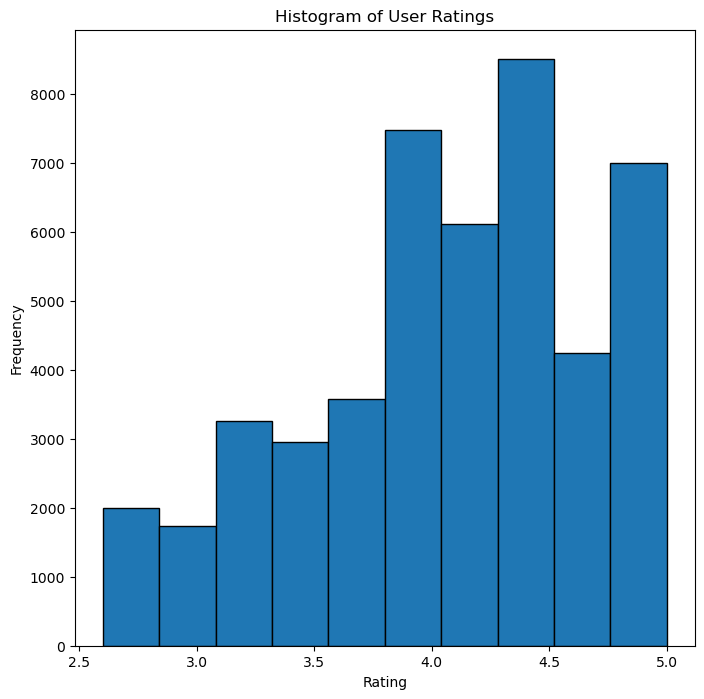

In [193]:
# Create a histogram for dependent variable
plt.figure(figsize=(8, 8))
plt.hist(cleaned_df["Rating"], bins=10, edgecolor='black')
plt.title('Histogram of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()